In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

---

# Task 10. Saxpy
By using `CuPy`, implement `SAXPY` function. The function is described in the picture.

### 10.1 
**Q1 Difference between CuPy and NumPy**

NumPy is designed to run on CPU so the parallelization capabilities are limited by the number of available CPU cores. CuPy is the implementation of Numpy adapted to be run on GPU through the CUDA library. Therefore, the usage of CuPy allows achieving a superior speed-up utilizing GPU resources.

**Q2 How does CuPy handles data transfer between CPU and GPU**

CuPy uses memory pool for memory allocations by default. For the purposes of CPU-to-GPU data transfer CuPy used pinned memory pool (non-swappable CPU memory). The memory pool significantly improves the performance by mitigating the overhead of memory allocation and CPU/GPU synchronization.



### 10.2 SAXPY implementation

In [2]:
def saxpy(x: cp.array, y: cp.array, a: float) -> cp.array:
    assert x.shape[0] == y.shape[0], 'x and y should be the same lenth!'
    return a * x + y

### 10.3 NumPy vs CuPy profiling

In [3]:
alpha : float = 3.9
n_points : int = 5
exe_time_cp, exe_time_np, arr_size = np.zeros(n_points), np.zeros(n_points), np.zeros(n_points)
for n in range(n_points):
    size : int = 10 ** (n + 3)
    arr_cp, arr_np  = cp.random.random(size), np.random.random(size)
    
    res_cp  = %timeit -n 100 -o saxpy(arr_cp, arr_cp, alpha)
    res_np = %timeit -n 100 -o saxpy(arr_np, arr_np, alpha)
    
    exe_time_cp[n], exe_time_np[n], arr_size[n]  = res_cp.average, res_np.average, arr_np.nbytes / 1e6

The slowest run took 163.88 times longer than the fastest. This could mean that an intermediate result is being cached.
706 µs ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.51 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
29.2 µs ± 393 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.77 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
29.7 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
139 µs ± 5.79 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
30.4 µs ± 2.06 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.31 ms ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 25.14 times longer than the fastest. This could mean that an intermediate result is being cached.
198 µs ± 271 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
36.6 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


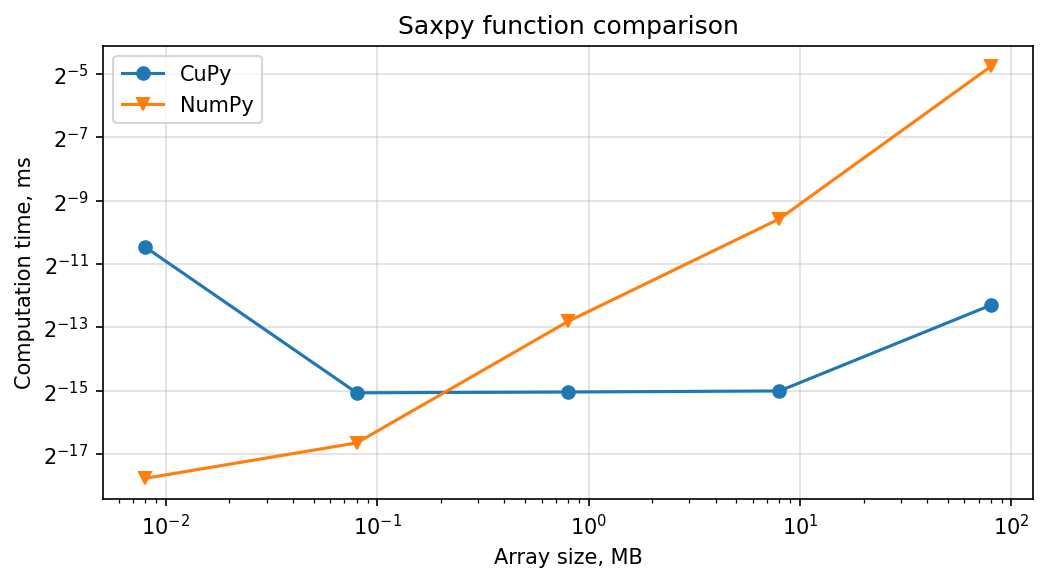

In [4]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax.plot(arr_size, exe_time_cp, '-o', label='CuPy')
ax.plot(arr_size, exe_time_np, '-v', label='NumPy')
ax.grid(alpha=.4)
ax.set_xscale('log',base=10)
ax.set_yscale('log',base=2)
ax.set_xlabel('Array size, MB')
ax.set_ylabel('Computation time, ms')
plt.legend()
plt.title('Saxpy function comparison')
plt.show()

---

# Task 11. CuPy-based Bifurcation map

By using **CuPy**, reimplement bifurcation map (Task 1).

### 11.1 CuPy & NumPy implementation (single function)

In [5]:
r_start, r_stop = 2.5, 4.0

def log_map(r: cp.array, x: cp.array)-> float:
    return r * x * (1 - x)

def bifurcation_rx(n : int=10000, iterations : int =500, cupy : bool=False) -> list:
    if cupy:
        r, x = cp.linspace(r_start, r_stop, n), cp.linspace(0, 1, n) # CuPy arrays
    else:
        r, x = np.linspace(r_start, r_stop, n), np.linspace(0, 1, n) # NumPy arrays
    rx_values = []
    for i in range(iterations):
        x = log_map(r, x)
        if i >= (iterations - 100): # Treashlod
            rx_values.append((r, x))
    return rx_values

def plot_bifurcation(rx_values: list) -> None:
    fig, ax1 = plt.subplots(figsize=(16, 8), dpi=200)
    for r, x in rx_values:
        ax1.plot(r, x, ',') # Use a small marker to faster rende
        ax1.set_ylim(0, 1)
    ax1.set_xlim(r_start, r_stop)
    ax1.set_title("Bifurcation diagram")
    ax1.set_xlabel('$r$', fontsize=16)
    ax1.set_ylabel('$X_t$', fontsize=16)
    plt.grid(alpha=.4)
    plt.show()

### 11.2 Bifurcation profiling

### 11.3 NumPy vs CuPy comparison

In [6]:
n_points : int = 4
exe_time_cp, exe_time_np, n_iterations = np.zeros(n_points), np.zeros(n_points), np.zeros(n_points)
for n in range(n_points):
    n_iter : int = 10 ** (n + 3)
        
    res_cp  = %timeit -n 10 -o bifurcation_rx(n_iter, cupy=True)
    res_np = %timeit -n 10 -o bifurcation_rx(n_iter)
    
    exe_time_cp[n], exe_time_np[n], n_iterations[n]  = res_cp.average, res_np.average, n_iter

The slowest run took 5.42 times longer than the fastest. This could mean that an intermediate result is being cached.
35.2 ms ± 33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.75 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.3 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.61 ms ± 95.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.6 ms ± 85.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
162 ms ± 8.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
61.2 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.61 s ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


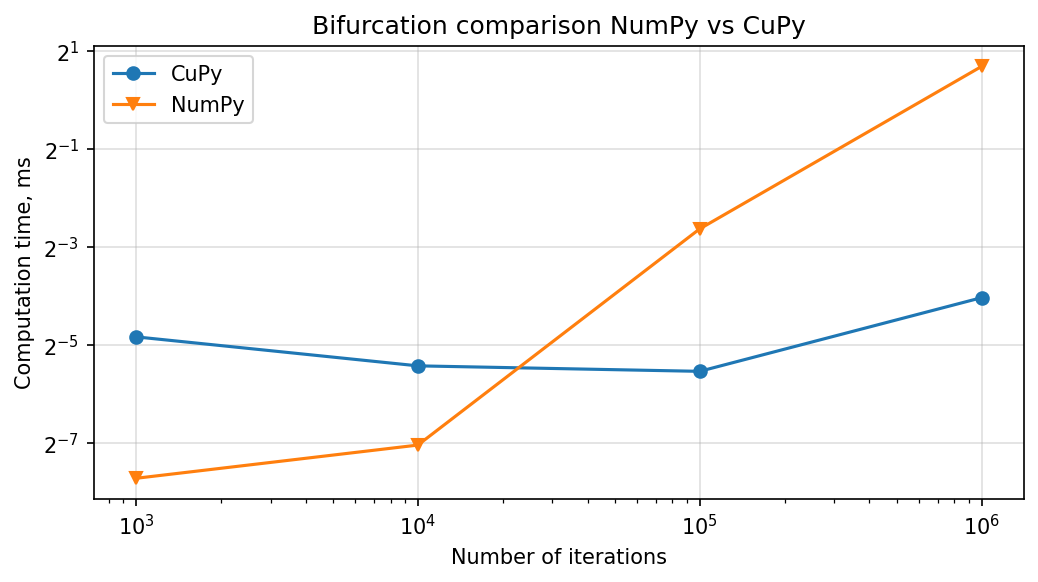

In [7]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax.plot(n_iterations, exe_time_cp, '-o', label='CuPy')
ax.plot(n_iterations, exe_time_np, '-v', label='NumPy')
ax.grid(alpha=.4)
ax.set_xscale('log',base=10)
ax.set_yscale('log',base=2)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Computation time, ms')
plt.legend()
plt.title('Bifurcation comparison NumPy vs CuPy')
plt.show()

---

# Task 12. Histogram


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the suggested function:
$$
 f(x) = (z^2(x) + z^3(x) - 200 \,\, z^4(x) )\,\,\sin(\,\,100000\,\,(x + 0.5)\,\,),
 \\
 \text{where    }\:\:\: z(x) = \sin(3\,\,x)-0.5
$$
* Plot function on the $x$ interval $[0,\,\, 1]$. Number of points = 10000000.
* Get minimal and maximal values of function on the interval $[0,\,\, 1]$: $f_{min}$ and $f_{max}$.
* Divide $y=f(x), \: (x \in [0,\,\, 1]) \:$ interval $[f_{min}, f_{max}]$ into $10$ $y=f(x)$ subintervals of length $\delta$ equal to $0.1 \,\, (f_{max}-f_{min})$: $[f_{min},\,\, f_{min} + \delta],\,\, [f_{min}+ \delta,\,\, f_{min} + 2 \,\, \delta],\,\, \dots,\,\, [f_{max}- \delta,\,\, f_{max}]$.
* Compute number of $y=f(x), \: (x \in [0,\,\, 1]) \:$ values in each subinterval. Use $\operatorname{cp.sum(\dots)}$
* Plot histogram.

In [8]:
n_points : int = 10000000
n_intervals : int  = 10

def calculate_hist(n_points : int = 10000000, n_intervals : int = 10, cupy: bool = False) -> tuple:
    kernel = cp if cupy else np

    def f(x: kernel.array) -> kernel.array:
        z = lambda x : kernel.sin(3 * x) - 0.5
        return (z(x) ** 2 + z(x) ** 3 - 200 * z(x) ** 4) * kernel.sin(100000 * (x + 0.5))

    x_val = kernel.linspace(0, 1, n_points)
    f_val = f(x_val) # y = f(x)

    f_left, f_right = kernel.min(f_val), kernel.max(f_val)
    delta = kernel.abs(f_left - f_right) * 0.1
    
    intervals = kernel.arange(kernel.float_(f_left), kernel.float_(f_right + delta), kernel.float_(delta))

    borders = ((intervals[i], intervals[i + 1])  for i in range(n_intervals))
    hist = kernel.array([kernel.sum((left <= f_val) & (f_val<= right)) for i, (left, right) in enumerate(borders)])
    
    return hist, intervals, f_val

### 12.1 Plotting $f(x)$

In [9]:
hist, intervals, f_val = calculate_hist(n_points)

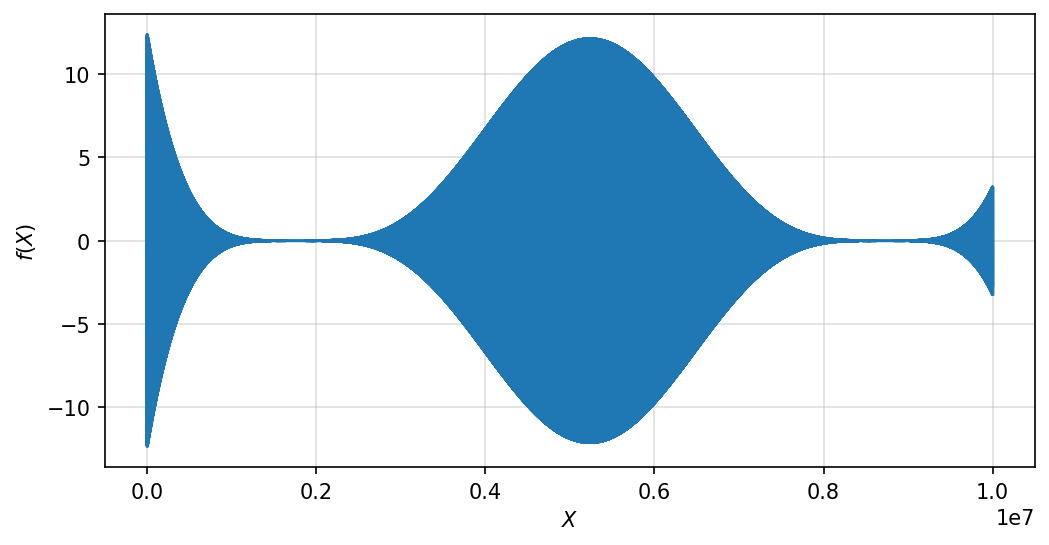

In [10]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
ax.plot(f_val)
ax.set_xlabel('$X$')
ax.set_ylabel('$f(X)$')
ax.grid(alpha=.4)
plt.show()

### 12.2 Histogram plot

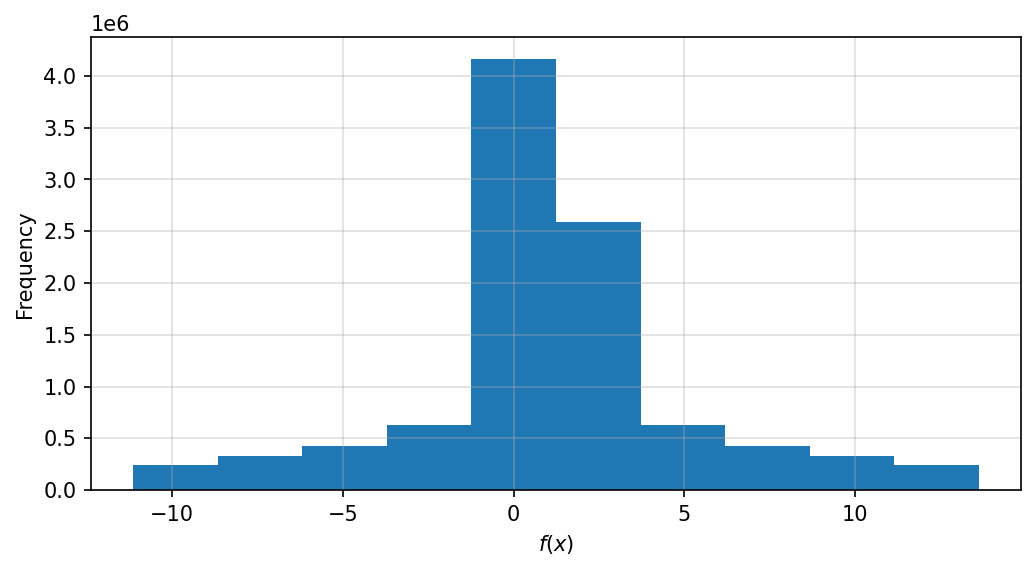

In [11]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax.bar(x=intervals[1:],height=hist, width=2.5)
ax.set_xlabel('$f(x)$')
ax.set_ylabel('Frequency')
ax.grid(alpha=.4)
plt.show()

### 12.3 NumPy vs CuPy implimentations comparison for different number of points

In [12]:
n_points : int = 5
exe_time_cp, exe_time_np, n_iterations = np.zeros(n_points), np.zeros(n_points), np.zeros(n_points)
for n in range(n_points):
    n_iter : int = 10 ** (n + 3)
        
    res_cp  = %timeit -n 10 -o calculate_hist(n_iter, cupy=True)
    res_np = %timeit -n 10 -o calculate_hist(n_iter)
    
    exe_time_cp[n], exe_time_np[n], n_iterations[n]  = res_cp.average, res_np.average, n_iter

The slowest run took 295.55 times longer than the fastest. This could mean that an intermediate result is being cached.
65.9 ms ± 158 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
374 µs ± 23.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.55 ms ± 36.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.38 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.69 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.3 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.3 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
127 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
116 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.46 s ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


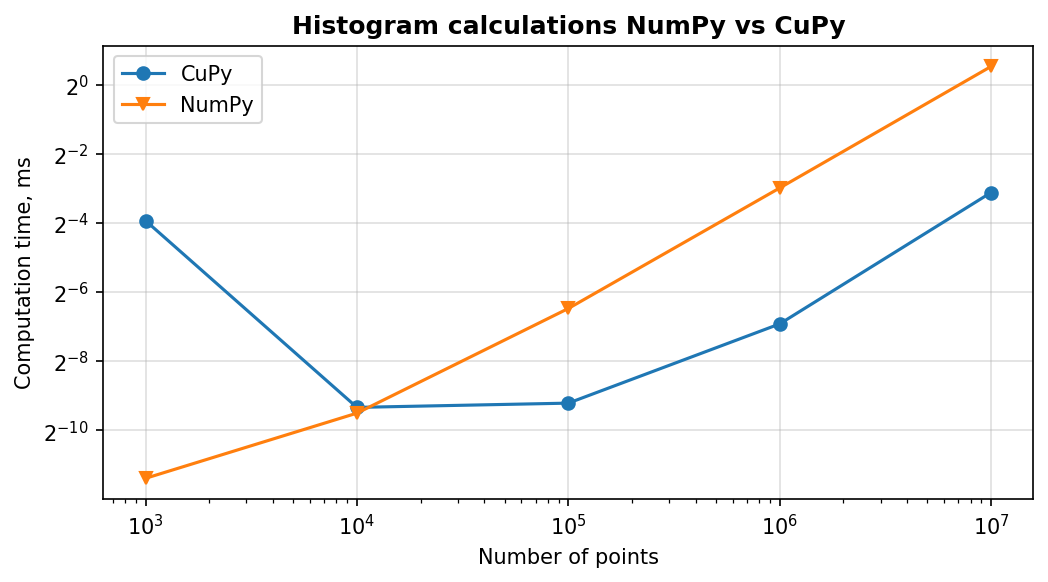

In [13]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax.plot(n_iterations, exe_time_cp, '-o', label='CuPy')
ax.plot(n_iterations, exe_time_np, '-v', label='NumPy')
ax.grid(alpha=.4)
ax.set_xscale('log',base=10)
ax.set_yscale('log',base=2)
ax.set_xlabel('Number of points')
ax.set_ylabel('Computation time, ms')
plt.legend()
plt.title('Histogram calculations NumPy vs CuPy', fontweight='bold')
plt.show()

---